# CTGAN Training for Weather Data Synthesis
This notebook implements a Conditional Tabular GAN (CTGAN) to generate synthetic weather data based on the Seattle weather dataset. We'll go through the following steps:
1. Data preparation and preprocessing
2. CTGAN model configuration and training
3. Synthetic data generation and validation
4. Quality assessment of synthetic data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle

# Set random seed for reproducibility
np.random.seed(42)

# Read the original dataset
df = pd.read_csv('../seattle-weather.csv')
df['date'] = pd.to_datetime(df['date'])

## Data Preprocessing
We'll prepare our data for the CTGAN model by:
1. Converting categorical variables to appropriate format
2. Scaling numerical features
3. Preparing the data structure for CTGAN training

In [2]:
# Prepare the data for CTGAN
# Extract numerical columns
numerical_columns = ['temp_max', 'temp_min', 'precipitation', 'wind']

# Create a copy of the dataframe with selected features
data_for_training = df[['weather'] + numerical_columns].copy()

# Scale numerical features
scaler = MinMaxScaler()
data_for_training[numerical_columns] = scaler.fit_transform(data_for_training[numerical_columns])

# Create models directory if it doesn't exist
import os
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save the scaler for later use
scaler_path = os.path.join(models_dir, 'weather_scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved scaler to {scaler_path}")

# Display the first few rows of preprocessed data
print("\nPreprocessed data sample:")
print(data_for_training.head())

# Display data info
print("\nDataset information:")
print(data_for_training.info())

Saved scaler to ../models\weather_scaler.pkl

Preprocessed data sample:
   weather  temp_max  temp_min  precipitation      wind
0  drizzle  0.387097  0.476378       0.000000  0.472527
1     rain  0.327957  0.389764       0.194991  0.450549
2     rain  0.357527  0.562992       0.014311  0.208791
3     rain  0.370968  0.500000       0.363148  0.472527
4     rain  0.282258  0.389764       0.023256  0.626374

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   weather        1461 non-null   object 
 1   temp_max       1461 non-null   float64
 2   temp_min       1461 non-null   float64
 3   precipitation  1461 non-null   float64
 4   wind           1461 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
None


## CTGAN Model Training
Now we'll configure and train the CTGAN model on our preprocessed data. We'll set appropriate hyperparameters for our weather data generation task.

In [3]:
# Initialize and train CTGAN model
ctgan = CTGAN(
    epochs=100,              # Number of training epochs
    batch_size=500,         # Batch size for training
    generator_dim=(128, 128),# Generator network dimensions
    discriminator_dim=(128, 128), # Discriminator network dimensions
    verbose=True
)

# Specify categorical columns for the model
discrete_columns = ['weather']

# Train the model
print("Starting CTGAN training...")
ctgan.fit(data_for_training, discrete_columns)
print("Training completed!")

# Save the trained model in the models directory
model_path = os.path.join(models_dir, 'weather_ctgan_model.pkl')
ctgan.save(model_path)
print(f"Model saved successfully to {model_path}!")

Starting CTGAN training...


Gen. (0.58) | Discrim. (0.07): 100%|██████████| 100/100 [00:08<00:00, 11.74it/s]

Training completed!
Model saved successfully to ../models\weather_ctgan_model.pkl!


## Generate and Evaluate Synthetic Data
Let's generate synthetic weather data and compare it with our original dataset to evaluate the quality of the generated data.

Saved synthetic data to ../data\synthetic_weather_data.csv


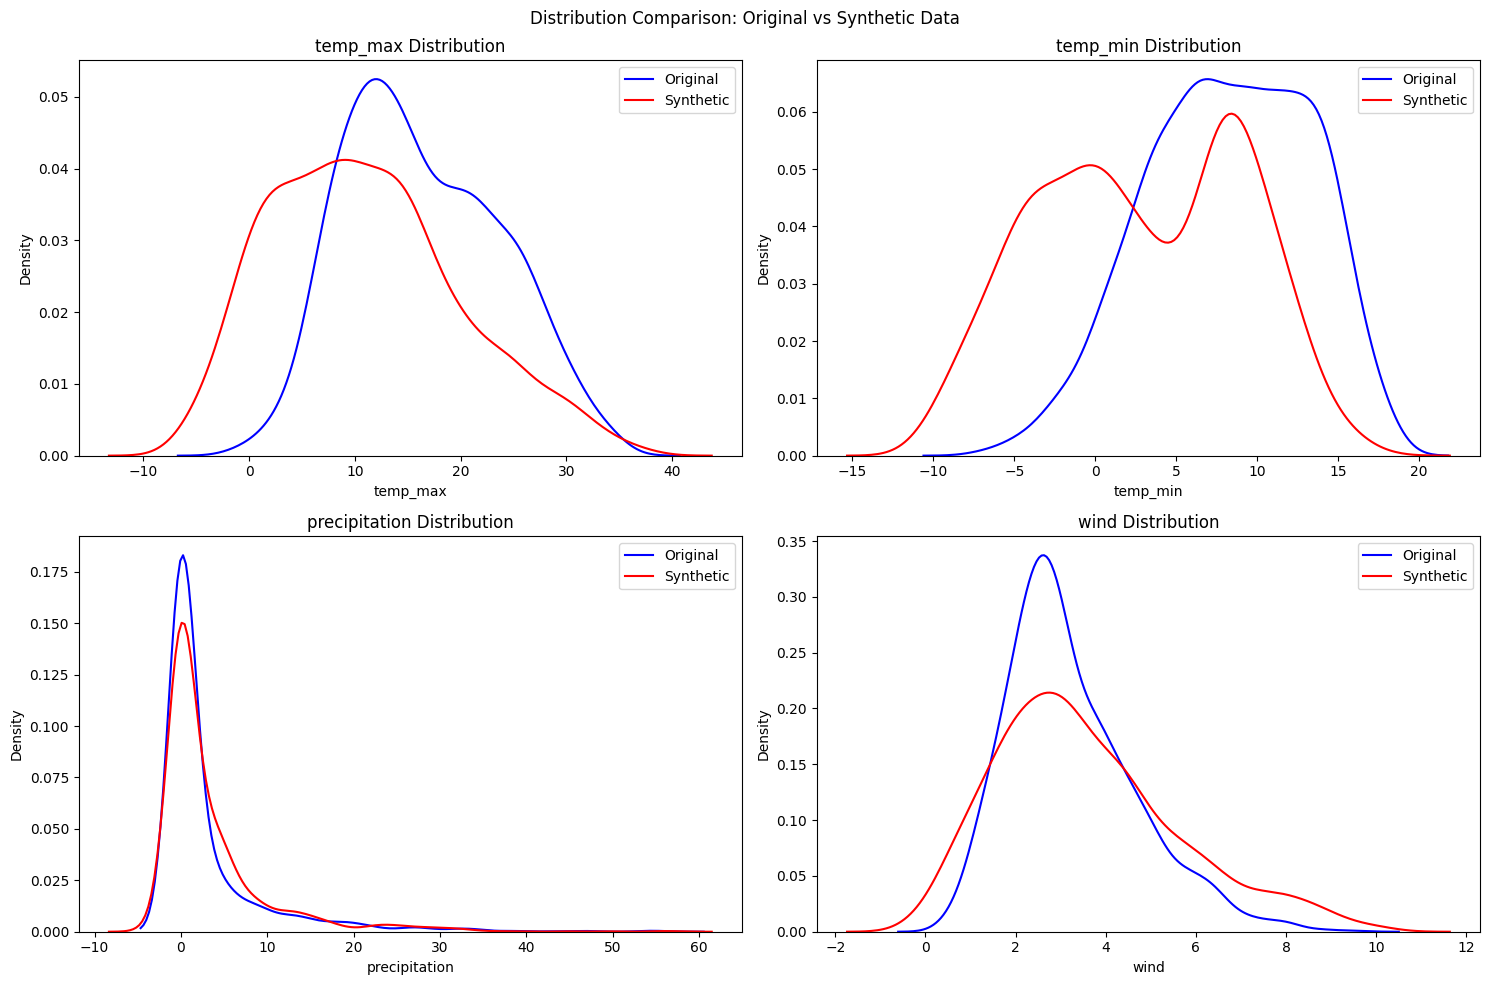

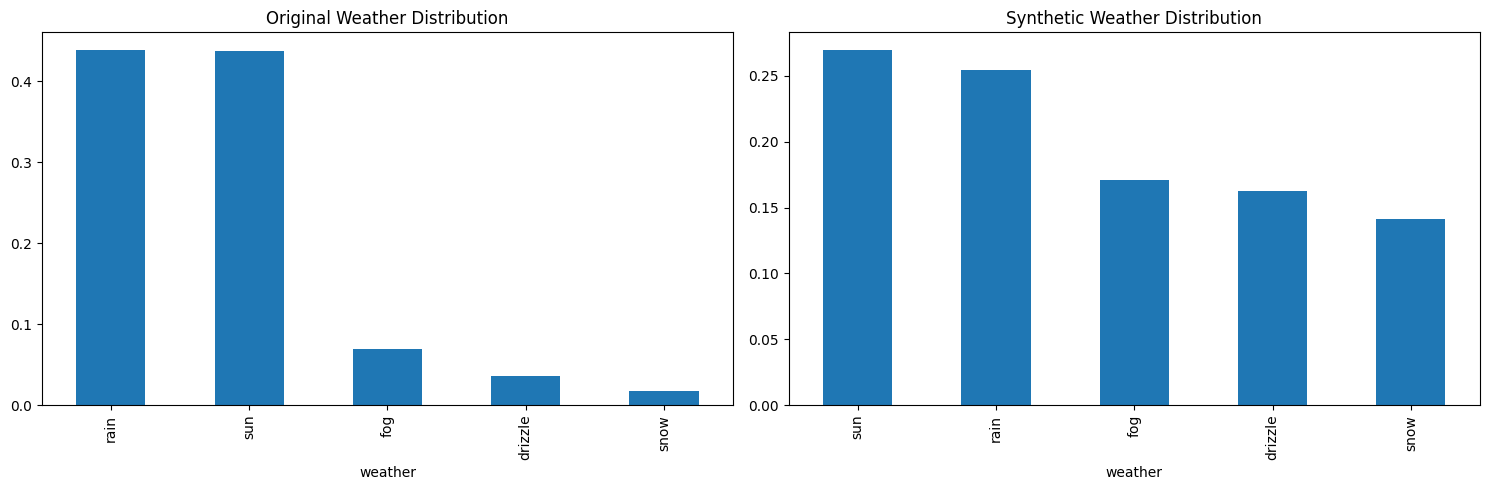


Summary Statistics Comparison:

Original Data:
          temp_max     temp_min  precipitation         wind
count  1461.000000  1461.000000    1461.000000  1461.000000
mean     16.439083     8.234771       3.029432     3.241136
std       7.349758     5.023004       6.680194     1.437825
min      -1.600000    -7.100000       0.000000     0.400000
25%      10.600000     4.400000       0.000000     2.200000
50%      15.600000     8.300000       0.000000     3.000000
75%      22.200000    12.200000       2.800000     4.000000
max      35.600000    18.300000      55.900000     9.500000

Synthetic Data:
          temp_max     temp_min  precipitation         wind
count  1461.000000  1461.000000    1461.000000  1461.000000
mean     10.941242     2.834014       3.436081     3.573171
std       8.913561     6.336739       6.562440     2.042301
min      -7.026188   -10.906014      -3.753480    -0.311458
25%       4.040767    -2.381010      -0.080631     2.095543
50%      10.168146     2.703667    

In [4]:
# Generate synthetic samples
n_samples = len(df)  # Generate same number of samples as original dataset
synthetic_data = ctgan.sample(n_samples)

# Inverse transform the scaled numerical features
synthetic_data[numerical_columns] = scaler.inverse_transform(synthetic_data[numerical_columns])

# Create data directory if it doesn't exist
data_dir = '../data'
os.makedirs(data_dir, exist_ok=True)

# Save synthetic data to CSV
synthetic_data_path = os.path.join(data_dir, 'synthetic_weather_data.csv')
synthetic_data.to_csv(synthetic_data_path, index=False)
print(f"Saved synthetic data to {synthetic_data_path}")

# Compare distributions of original and synthetic data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution Comparison: Original vs Synthetic Data')

for idx, col in enumerate(numerical_columns):
    i, j = idx // 2, idx % 2
    
    # Plot original data distribution
    sns.kdeplot(data=df[col], ax=axes[i,j], label='Original', color='blue')
    # Plot synthetic data distribution
    sns.kdeplot(data=synthetic_data[col], ax=axes[i,j], label='Synthetic', color='red')
    
    axes[i,j].set_title(f'{col} Distribution')
    axes[i,j].legend()

plt.tight_layout()
plt.show()

# Compare weather type distributions
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df['weather'].value_counts(normalize=True).plot(kind='bar', ax=ax[0], title='Original Weather Distribution')
synthetic_data['weather'].value_counts(normalize=True).plot(kind='bar', ax=ax[1], title='Synthetic Weather Distribution')
plt.tight_layout()
plt.show()

# Print summary statistics comparison
print("\nSummary Statistics Comparison:")
print("\nOriginal Data:")
print(df[numerical_columns].describe())
print("\nSynthetic Data:")
print(synthetic_data[numerical_columns].describe())

## Validation and Quality Checks
Let's perform some additional validation to ensure our synthetic data maintains important relationships and constraints found in real weather data.

Original Data:
Percentage of valid temperature relationships: 100.00%

Synthetic Data:
Percentage of valid temperature relationships: 75.63%


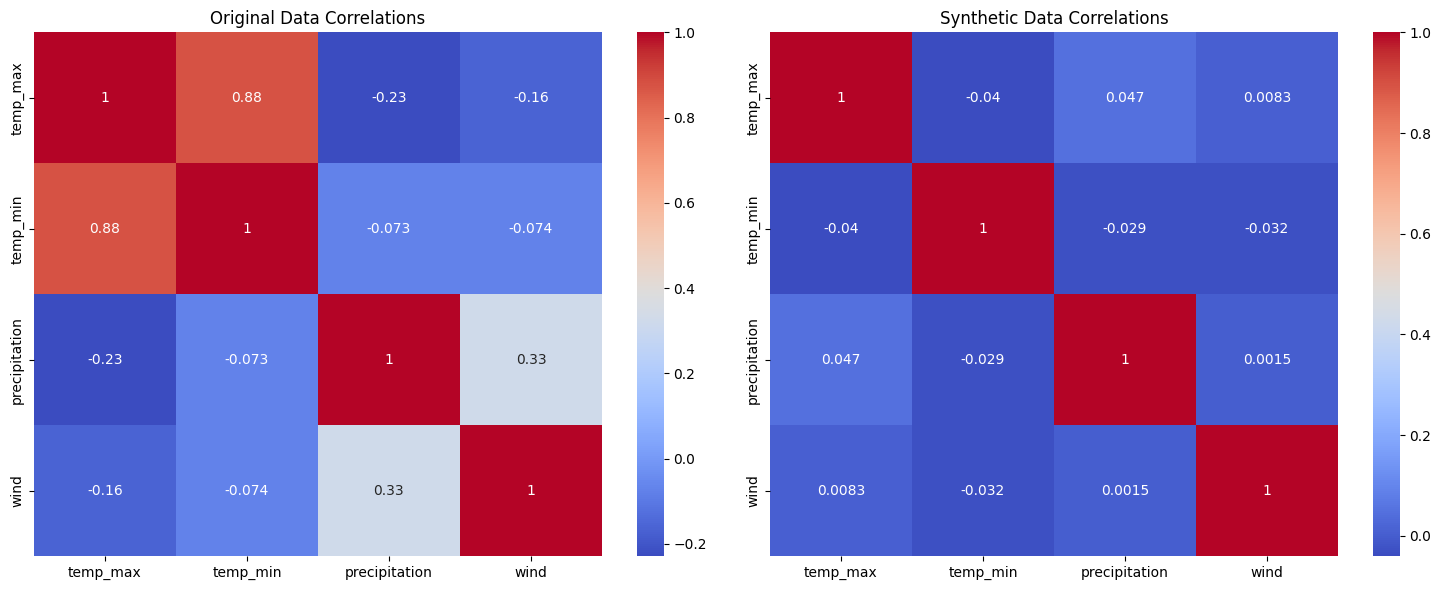


Correlation Difference (absolute):
               temp_max  temp_min  precipitation      wind
temp_max       0.000000  0.916095       0.275329  0.173114
temp_min       0.916095  0.000000       0.043695  0.042407
precipitation  0.275329  0.043695       0.000000  0.326526
wind           0.173114  0.042407       0.326526  0.000000


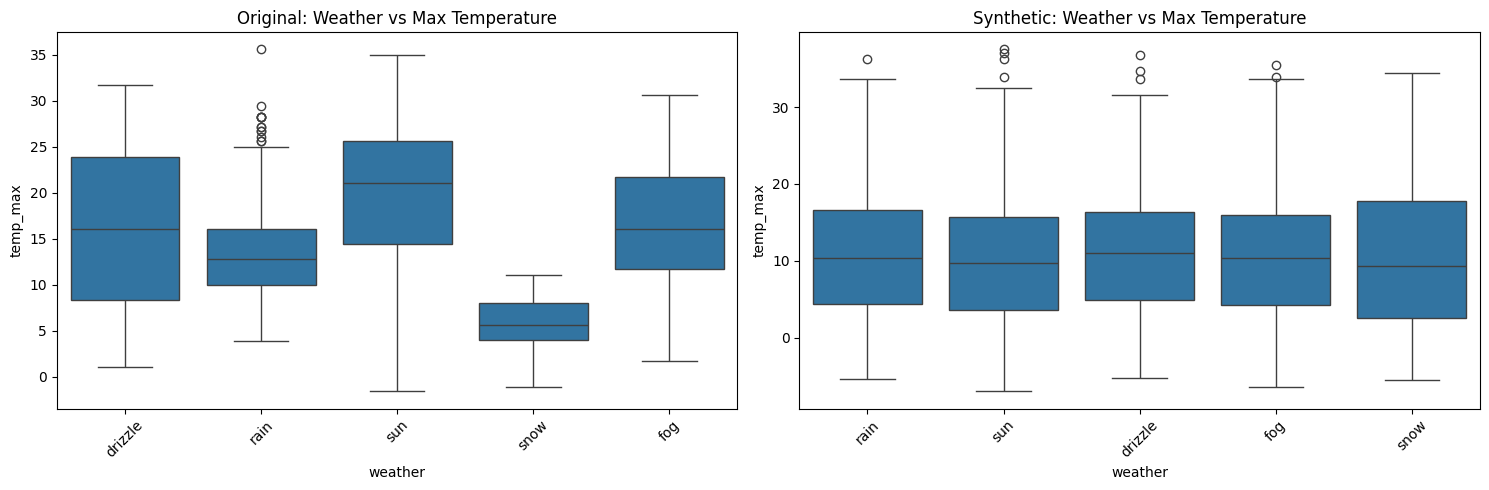


Temperature Statistics by Weather Type:

Original Data:
         count       mean       std  min     25%   50%     75%   max
weather                                                             
drizzle   53.0  15.926415  8.812036  1.1   8.300  16.1  23.900  31.7
fog      101.0  16.757426  6.774723  1.7  11.700  16.1  21.700  30.6
rain     641.0  13.454602  4.973029  3.9  10.000  12.8  16.100  35.6
snow      26.0   5.573077  3.109155 -1.1   4.025   5.6   8.025  11.1
sun      640.0  19.861875  7.698258 -1.6  14.400  21.1  25.600  35.0

Synthetic Data:
         count       mean       std       min       25%        50%        75%  \
weather                                                                         
drizzle  238.0  11.631985  8.635515 -5.261722  4.847930  11.048286  16.321056   
fog      250.0  10.953520  8.817151 -6.397295  4.221216  10.415123  16.006952   
rain     372.0  11.015662  8.918125 -5.448051  4.372016  10.309001  16.552429   
snow     207.0  10.601040  9.448825 -5

In [5]:
# Check temperature constraints (max temp should be greater than min temp)
def check_temperature_constraint(data):
    valid_temps = (data['temp_max'] >= data['temp_min']).mean() * 100
    print(f"Percentage of valid temperature relationships: {valid_temps:.2f}%")
    
print("Original Data:")
check_temperature_constraint(df)
print("\nSynthetic Data:")
check_temperature_constraint(synthetic_data)

# Check correlation preservation
original_corr = df[numerical_columns].corr()
synthetic_corr = synthetic_data[numerical_columns].corr()

# Plot correlation matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(original_corr, annot=True, cmap='coolwarm', ax=ax1)
ax1.set_title('Original Data Correlations')

sns.heatmap(synthetic_corr, annot=True, cmap='coolwarm', ax=ax2)
ax2.set_title('Synthetic Data Correlations')

plt.tight_layout()
plt.show()

# Calculate correlation difference
correlation_difference = abs(original_corr - synthetic_corr)
print("\nCorrelation Difference (absolute):")
print(correlation_difference)

# Check weather-temperature relationships
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='weather', y='temp_max', data=df, ax=axes[0])
axes[0].set_title('Original: Weather vs Max Temperature')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='weather', y='temp_max', data=synthetic_data, ax=axes[1])
axes[1].set_title('Synthetic: Weather vs Max Temperature')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print basic statistics for each weather type
print("\nTemperature Statistics by Weather Type:")
print("\nOriginal Data:")
print(df.groupby('weather')['temp_max'].describe())
print("\nSynthetic Data:")
print(synthetic_data.groupby('weather')['temp_max'].describe())